In [213]:
%matplotlib inline

import pandas as pd
import numpy as np

from pandas.api.types import CategoricalDtype

from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import matplotlib.dates as mdates

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

import dataStatsAnalysis as dsa
import dataStatsPlotting as dsp

dsp.SetParams()

In [214]:
# Load the hypothesis test superclass
class UnimplementedMethodException(Exception):
    """Exception if someone calls a method that should be overridden."""

class HypothesisTest():
    """Hypothesis test superclass. 
    """

    def __init__(self, data, tail='right', iters=1000):
        """Initializes the hypothesis test.

        data: data in whatever form is relevant
        """
        self.data = data
        self.tail = tail
        self.iters = iters
        self.PrepareData(data)
        self.TestStat()
        self.rv = self.ComputeRv()

    # Provide the functionality to convert the data into the format needed 
    # for use in ComputeRv and Power functions. 
    # Ex. Convert to array, split data into component groups, etc. 
    # The self data variables must be created in the function, not returned. 
    # See child classes for examples
    def PrepareData(self, data):
        UnimplementedMethodException()
        
    # This function only needs to be written in the case of a null hypothesis based test. 
    # The self.test_stat needs to be created in the function, not returned. 
    # In the case of an alternative hypothesis based test 
    # test_stat will be provided via a class parameter. 
    # See child classes for examples
    def TestStat(self):
        pass
    
    # Provide the functionality that computes the sampling distribution and rv for the data. 
    # See child classes for examples
    def ComputeRv(self):
        UnimplementedMethodException()
        
    # Provide the functionality that computes the power of the hypothesis test.
    # The code in the for loop must first create new data for the run, 
    # which simulates taking another sample from the population'and then run the hypothesis test.
    # This is the done repeatedly to compute the power of the test.
    # See child classes for examples
    def Power(self):
        UnimplementedMethodException()
    
    def PValue(self):
        """Computes the distribution of the test statistic and p-value.

        returns: float p-value
        """
        if self.tail == 'left':
            pvalue = self.rv.cdf(self.test_stat)
        elif self.tail == 'right':
            pvalue = 1 - self.rv.cdf(self.test_stat)
        else:
            raise Exception('The value of \'tail\' can only be either \'left\' or \'right\'')

        return pvalue

    def MinMaxTestStat(self):
        """Returns the smallest and largest test statistics in the sampling distribution.
        """
        return min(self.rv.xk), max(self.rv.xk)

    def PlotCdf(self):
        """Draws a Cdf with a vertical line at the test stat.
        """      
        plt.plot(self.rv.xk, self.rv.cdf(self.rv.xk), color='C0', lw=2) # pylint: disable=no-member
        
        plt.axvline(self.test_stat, color='C1', lw=1.3)
        

### One-sample mean hypothesis test

In [215]:
class HTMean(HypothesisTest):
    """A one-sample mean hypothesis test. 
    A test_stat to represent the null hypothesis must be provided. 
    This test can only produce a onesided pvalue.
    """  
    # For tests that resample to build a distribution for the alternative hypothesis 
    # a test_stat parameter must be included in __init__ to represent the null hypothesis
    # This test_stat is made an attribute of the class below
    def __init__(self, data, test_stat, tail='right', iters=1000):
        self.test_stat = test_stat
        HypothesisTest.__init__(self, data, tail, iters)

    def PrepareData(self, data):
        self.data = np.array(self.data)
        
    def ComputeRv(self):       
        # Build the sampling distribution
        mean_estimates = [np.random.choice(self.data, size=len(self.data), replace=True).
                          mean() for _ in range(self.iters)]

        return dsa.DiscreteRv(mean_estimates)

    def Power(self, alpha=0.05, num_runs=1000):        
        pvalue_count = 0
        
        for _ in range(num_runs):
            # Create run_data that simulates taking another sample from the population
            run_data = np.random.choice(self.data, size=len(self.data), replace=True)
        
            # Run the hypothesis test with run_data
            # Reduce iters to 100 to reduce computation time
            test = HTMean(run_data, test_stat=self.test_stat, tail=self.tail, iters=100)
            pvalue = test.PValue()
            
            if pvalue < alpha:
                pvalue_count += 1
            
        return pvalue_count / num_runs

In [216]:
data1 = np.random.randint(17,23,size=100)
data1

array([18, 22, 21, 19, 22, 21, 18, 21, 22, 20, 22, 21, 21, 17, 19, 21, 20,
       22, 17, 20, 18, 21, 18, 18, 19, 18, 17, 19, 22, 17, 20, 18, 22, 21,
       21, 19, 19, 19, 19, 22, 19, 22, 21, 18, 21, 18, 20, 19, 21, 18, 17,
       17, 19, 22, 21, 18, 20, 22, 22, 19, 22, 19, 21, 22, 21, 19, 21, 17,
       17, 22, 18, 17, 19, 19, 20, 21, 22, 20, 20, 21, 21, 18, 20, 17, 19,
       18, 19, 21, 19, 18, 22, 17, 17, 21, 22, 21, 22, 18, 21, 22])

In [217]:
htmean = HTMean(data1, test_stat=19.15, tail='left')

In [218]:
htmean.PValue()

0.0

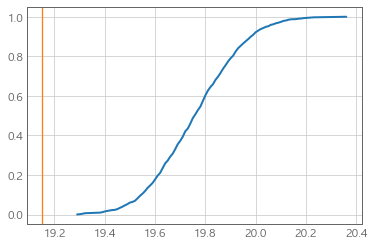

In [219]:
htmean.PlotCdf()

In [220]:
htmean.MinMaxTestStat()

(19.29, 20.36)

In [221]:
# This seems to be working
# But it's significantly slower than my dsa power test
# The results are the same when I use alternative='left' with the dsa power test
# I'm pretty sure this is right since the hypothesis test can only test in one direction
htmean.Power()

0.968

In [222]:
# Compare with my original power test
dsapt = dsa.PTMean(data1, test_stat=19.15, alternative='left')
dsapt.Power()

0.967

In [223]:
data1.mean()

19.76

In [224]:
# Seems to be working, same result as using resample function
results1 = dsa.ResampleMean(data1, iters=1000)
dsa.PValueFromEstimates(results1, 19.15, tail='left')

0.0

### Diff means hypothesis tests

In [225]:
class HTDiffMeansH0(HypothesisTest):
    """A difference of means hypothesis test. 
    Uses permutation to build a sampling distrubition that represents the null hypothesis.
    """
    def __init__(self, data, onesided=False, tail='right', iters=1000):
        self.onesided = onesided
        HypothesisTest.__init__(self, data, tail, iters)

    def PrepareData(self, data):
        a, b = data
        self.a = np.array(a)
        self.b = np.array(b)
        
    # For tests that resample to build a distribution for the null hypothesis 
    # the calculation of the test stat must be provided. 
    # The calculation must create self.test_stat, not return the value.
    # In the case of a twosided test the absolute value of the difference in means is used
    def TestStat(self):      
        if self.onesided == False:
            self.test_stat = abs(self.a.mean() - self.b.mean())
        elif self.onesided == True:
            self.test_stat = self.a.mean() - self.b.mean()
        else:
            raise TypeError('\'onesided\' parameter only accepts Boolean True or False')
        
    def ComputeRv(self):
        # Create the pooled data
        pooled_data = np.hstack((self.a, self.b))
        # Compute the size of a, size of b is just the rest
        a_size = len(self.a)
        
        # Build the sampling distribution
        diff_mean_results = []
        
        if self.onesided == False:
            for _ in range(self.iters):
                np.random.shuffle(pooled_data)
                group1 = pooled_data[:a_size]
                group2 = pooled_data[a_size:]
                result = abs(group1.mean() - group2.mean())
                
                diff_mean_results.append(result)
                    
        elif self.onesided == True:
            for _ in range(self.iters):
                np.random.shuffle(pooled_data)
                group1 = pooled_data[:a_size]
                group2 = pooled_data[a_size:]
                result = group1.mean() - group2.mean()
                
                diff_mean_results.append(result)
                
        else:
            raise TypeError('\'onesided\' parameter only accepts Boolean True or False')
            
        return dsa.DiscreteRv(diff_mean_results)
    
    def Power(self, alpha=0.05, num_runs=1000):      
        pvalue_count = 0
        
        for _ in range(num_runs):
            # Create run_data that simulates taking another sample from the population
            sample1 = np.random.choice(self.a, size=len(self.a), replace=True)
            sample2 = np.random.choice(self.b, size=len(self.b), replace=True)
            run_data = sample1, sample2
        
            # Run the hypothesis test with run_data
            test = HTDiffMeansH0(run_data, onesided=self.onesided, tail=self.tail, iters=100)
            pvalue = test.PValue()
            
            if pvalue < alpha:
                pvalue_count += 1
            
        return pvalue_count / num_runs

In [226]:
import first
live, firsts, others = first.MakeFrames()

In [227]:
data2 = [firsts.prglngth.values, others.prglngth.values]

In [228]:
diffmeansHo = HTDiffMeansH0(data2)
diffmeansHo.PValue()

0.16599999999999937

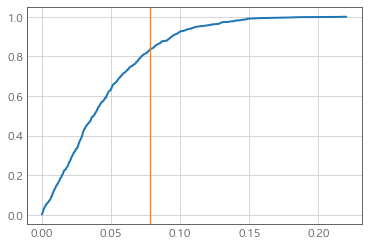

In [229]:
diffmeansHo.PlotCdf()

In [230]:
diffmeansHo.Power()

0.305

In [231]:
# Seems to be working, result is the same for new HT test and the resampling function below
# onesided also seems to be working
diffmeansHo_results = dsa.ResampleDiffMeansH0(data2[0], data2[1])
dsa.PValueFromEstimates(diffmeansHo_results[1], diffmeansHo_results[0])

0.17199999999999938

In [232]:
class HTDiffMeansHa(HypothesisTest):
    """A difference of means hypothesis test. 
    Uses resampling to build a sampling distrubition that represents the alternative hypothesis.
    """
    # For tests that resample to build a distribution for the alternative hypothesis 
    # a test_stat parameter must be included in __init__ to represent the null hypothesis
    # This test_stat is made an attribute of the class below
    def __init__(self, data, test_stat, tail='right', iters=1000):
        self.test_stat = test_stat
        HypothesisTest.__init__(self, data, tail, iters)

    def PrepareData(self, data):
        a, b = data
        self.a = np.array(a)
        self.b = np.array(b)

    def ComputeRv(self):      
        # Build the sampling distribution
        diff_mean_results = []
        
        for _ in range(self.iters):
            group1 = np.random.choice(self.a, size=len(self.a), replace=True)
            group2 = np.random.choice(self.b, size=len(self.b), replace=True)
            result = group1.mean() - group2.mean()
                
            diff_mean_results.append(result)
           
        return dsa.DiscreteRv(diff_mean_results)
    
    def Power(self, alpha=0.05, num_runs=1000):      
        pvalue_count = 0
        
        for _ in range(num_runs):
            # Create run data
            sample1 = np.random.choice(self.a, size=len(self.a), replace=True)
            sample2 = np.random.choice(self.b, size=len(self.b), replace=True)
            run_data = sample1, sample2
        
            # Run the hypothesis test with run_data
            test = HTDiffMeansHa(run_data, test_stat=self.test_stat, tail=self.tail, iters=100)
            pvalue = test.PValue()
            
            if pvalue < alpha:
                pvalue_count += 1
            
        return pvalue_count / num_runs

In [233]:
diffmeansHa = HTDiffMeansHa(data2, 0, tail='left')
diffmeansHa.PValue()

0.09100000000000007

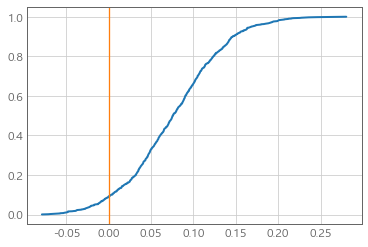

In [234]:
diffmeansHa.PlotCdf()

In [235]:
# It's working.
diffmeansHa_results = dsa.ResampleDiffMeansHa(data2[0], data2[1])
dsa.PValueFromEstimates(diffmeansHa_results[1], 0, tail='left')

0.07400000000000005

In [236]:
# It's a bit higher power than H0, which is because this is onesided
# The result matches with using onesided=True in the H0 version class
diffmeansHa.Power()

0.395

In [237]:
# The result is quite different from above, this is because the Ha test is one-sided
dsafiffmeansHa = dsa.PTDiffMeansHa(data2, 0)
dsafiffmeansHa.Power()

0.289

### Correlation tests

In [238]:
class HTCorrelationH0(HypothesisTest):
    """A correlation hypothesis test. 
    Uses permutation to build a sampling distrubition that represents the null hypothesis.
    """
    def __init__(self, data, onesided=False, tail='right', iters=1000, method='pearson'):
        self.onesided = onesided
        self.method = method
        HypothesisTest.__init__(self, data, tail, iters)

    def PrepareData(self, data):
        x, y = data
        self.x = np.array(x)
        self.y = np.array(y)
        
    # For tests that resample to build a distribution for the null hypothesis 
    # the calculation of the test stat must be provided.
    # In the case of a twosided test the absolute value of the difference in means is used
    def TestStat(self):
        if (self.onesided == False) & (self.method == 'pearson'):
            self.test_stat = abs(stats.pearsonr(self.x , self.y)[0])
        elif (self.onesided == False) & (self.method == 'spearman'):
            self.test_stat = abs(stats.spearmanr(self.x , self.y)[0])
        elif (self.onesided == True) & (self.method == 'pearson'):
            self.test_stat = stats.pearsonr(self.x , self.y)[0]
        elif (self.onesided == True) & (self.method == 'spearman'):
            self.test_stat = stats.spearmanr(self.x , self.y)[0]
        else:
            raise ValueError('\'onesided\' parameter only accepts Boolean True or False, ' +
                             'and \'method\' only accepts \'pearson\' or \'spearman\'')
        
    def ComputeRv(self):
        # Build the sampling distribution
        corrs = []
        
        if (self.onesided == False) & (self.method == 'pearson'):
            for _ in range(self.iters):
                x_perm = np.random.permutation(self.x)
                r = abs(stats.pearsonr(x_perm , self.y)[0])
                corrs.append(r)
                
        elif (self.onesided == False) & (self.method == 'spearman'):
            for _ in range(self.iters):
                x_perm = np.random.permutation(self.x)
                r = abs(stats.spearmanr(self.x , self.y)[0])
                corrs.append(r)
        
        elif (self.onesided == True) & (self.method == 'pearson'):
            for _ in range(self.iters):
                x_perm = np.random.permutation(self.x)
                r = stats.pearsonr(x_perm , self.y)[0]
                corrs.append(r)
                
        elif (self.onesided == True) & (self.method == 'spearman'):
            for _ in range(self.iters):
                x_perm = np.random.permutation(self.x)
                r = stats.spearmanr(self.x , self.y)[0]
                corrs.append(r)
    
        else:
            raise ValueError('\'onesided\' parameter only accepts Boolean True or False, ' +
                             'and \'method\' only accepts \'pearson\' or \'spearman\'')   
        
        return dsa.DiscreteRv(corrs)
        
    def Power(self, alpha=0.05, num_runs=1000):      
        # Build the df to use to make the run data
        df = pd.DataFrame({'x':self.x, 'y': self.y})
        
        pvalue_count = 0
        
        for _ in range(num_runs):
            # Create run data
            run_df = df.sample(n=len(df), replace=True)
            run_x = run_df.x.values
            run_y = run_df.y.values
            run_data = run_x, run_y
        
            # Run the hypothesis test with run_data
            test = HTCorrelationH0(run_data, onesided=self.onesided, tail=self.tail, 
                                   iters=100, method=self.method)
            pvalue = test.PValue()
            
            if pvalue < alpha:
                pvalue_count += 1
            
        return pvalue_count / num_runs

In [239]:
car = sns.load_dataset('car_crashes')
car.head(3)

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
0,18.8,7.332,5.640,18.048,15.040,784.55,145.08,AL
1,18.1,7.421,4.525,16.290,17.014,1053.48,133.93,AK
2,18.6,6.510,5.208,15.624,17.856,899.47,110.35,AZ


In [240]:
stats.pearsonr(car.no_previous, car.ins_premium)

(-0.15689520004339752, 0.2715478689798989)

In [241]:
# Seems to be working, variation is: 0.25~0.29 for two-tailed, 0.12~0.15 for one-tailed
data3 = car.no_previous, car.ins_premium
car_hyp = HTCorrelationH0(data3, onesided=False, tail='right', method='pearson')
car_hyp.PValue()

0.2969999999999995

In [242]:
# Compare my new function with the old one
# Variation is about .25 ~ .30
# Similar to results from my new hypothesis test
HTcorrperm = dsa.HTCorrelationPermute(data3)
HTcorrperm.PValue()

0.278

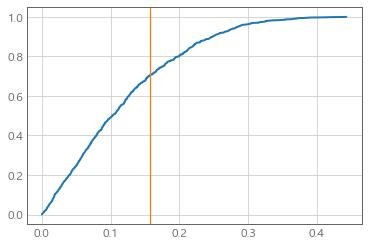

In [243]:
car_hyp.PlotCdf()

In [244]:
# Seems to be working, result is the same as obtained in the power test creation notebook
car_hyp.Power()

0.234

In [245]:
class HTCorrelationHa(HypothesisTest):
    """A correlation hypothesis test. 
    Uses permutation to build a sampling distrubition that represents the null hypothesis.
    """
    def __init__(self, data, test_stat, tail='right', iters=1000, method='pearson'):
        self.test_stat = test_stat
        self.method = method
        HypothesisTest.__init__(self, data, tail, iters)

    def PrepareData(self, data):
        x, y = data
        self.x = np.array(x)
        self.y = np.array(y)
        self.df = pd.DataFrame({'x':self.x, 'y': self.y})
              
    def ComputeRv(self):
        # Build the sampling distribution
        corrs = []
                
        if self.method == 'pearson':
            for _ in range(self.iters):
                sample = self.df.sample(n=len(self.df), replace=True)
                r = stats.pearsonr(sample.x, sample.y)[0]
                corrs.append(r)
                
        elif self.method == 'spearman':
            for _ in range(self.iters):
                sample = self.df.sample(n=len(self.df), replace=True)
                r = stats.spearmanr(sample.x, sample.y)[0]
                corrs.append(r)
    
        else:
            raise Exception('Must enter either \'pearson\' or \'spearman\ ' +
                            'as a string for the \'method\' argument')   
        
        return dsa.DiscreteRv(corrs)
    
    def Power(self, alpha=0.05, num_runs=1000):    
        pvalue_count = 0
        
        for _ in range(num_runs):
            # Create run data
            run_df = self.df.sample(n=len(self.df), replace=True)
            run_x = run_df.x.values
            run_y = run_df.y.values
            run_data = run_x, run_y
        
            # Run the hypothesis test with run_data
            test = HTCorrelationHa(run_data, test_stat=self.test_stat, tail=self.tail, 
                                   iters=100, method=self.method)
            pvalue = test.PValue()
            
            if pvalue < alpha:
                pvalue_count += 1
            
        return pvalue_count / num_runs

In [246]:
# Variation is : 0.16 ~ 0.19
# These results close to those of the one-sided null hypothesis version (see above), but a bit higher
car_hypa = HTCorrelationHa(data3, 0, method='pearson')
car_hypa.PValue()

0.17799999999999938

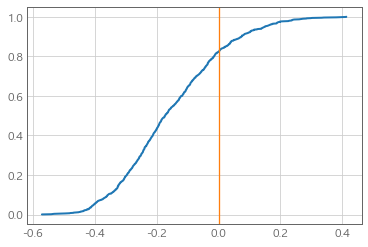

In [247]:
car_hypa.PlotCdf()

In [248]:
# Seems to be working
# Gives the same results as the one-sided test in the power test creation notebook
car_hypa.Power()

0.281

### Chi square tests

In [249]:
class HTChiSquare(HypothesisTest):
    """A chi square hypothesis test. 
    Uses resampling of the expected sequence to simulate the null hypothesis 
    and build the null hypothesis sampling distribution. 
    Takes data in the form of two sequences: data = observed, expected.
    """
    def PrepareData(self, data):
        self.observed, self.expected = data
        self.observed = np.array(self.observed)
        self.expected = np.array(self.expected)
        
        # Check that sum of values are equal
        if np.isclose(sum(self.observed), sum(self.expected)) == False:
            raise ValueError('The sum of the values for observed and expected must be equal.')
        
    def TestStat(self):
        self.test_stat = sum((self.observed - self.expected)**2 / self.expected)
        
    def ComputeRv(self):
        # Calculate the variables needed for resampling        
        n = sum(self.expected)
        values = list(range(len(self.expected)))
        p_exp = self.expected/sum(self.expected)
        
        # Build the sampling distribution
        chis = []
        
        for _ in range(self.iters):          
            hist = Counter({x:0 for x in values}) # Initialize a Counter with zero values
            hist.update(np.random.choice(values, size=n, replace=True, p=p_exp))
            sorted_hist = sorted(hist.items())
            model_observed = np.array([x[1] for x in sorted_hist])
            chi = sum((model_observed - self.expected)**2 / self.expected)
                
            chis.append(chi)
            
        return dsa.DiscreteRv(chis)
    
    def Power(self, alpha=0.05, num_runs=1000):    
        pvalue_count = 0
        
        for _ in range(num_runs):
            # Create a new run_observed by resampling the observed sequence 
            # Then create the new run_data using run_observed and the original expected sequence
            n = sum(self.observed)
            values_obs = list(range(len(self.observed)))
            p_obs = self.observed/sum(self.observed)
        
            hist = Counter({x:0 for x in values_obs})
            hist.update(np.random.choice(values_obs, size=n, replace=True, p=p_obs))
            sorted_hist = sorted(hist.items())
            run_observed = np.array([x[1] for x in sorted_hist])
            run_data = run_observed, self.expected

            # Run the hypothesis test with run_data
            test = HTChiSquare(run_data, tail=self.tail, iters=100)
            pvalue = test.PValue()
            
            if pvalue < alpha:
                pvalue_count += 1
            
        return pvalue_count / num_runs

In [250]:
observed = [11,7,4,7,12,16,13]
expected = [10,10,10,10,10,10,10]
observed = np.array(observed)
expected = np.array(expected)
data4 = observed, expected

In [251]:
# Getting values of 0.09~0.12, seems to compare well with old class below
htchi = HTChiSquare(data4)
htchi.PValue()

0.11699999999999944

In [252]:
# Compare with my old hypothesis test class (0.09~0.13)
htchi2 = dsa.HTChiSquare(data4)
htchi2.PValue()

0.108

In [253]:
# This result is the same that of my existing function if alternative is onesided and set to 'right'
# If I want to simulate a two-sided test I can just use alpha=0.25
htchi.Power()

0.692

In [254]:
# Compare with my dsa power class results
dsachipower = dsa.PTChiSquare(data4, alternative='right')
dsachipower.Power()

0.714

In [255]:
class HTChiSquareContingency(HypothesisTest):
    """A chi square contingency table hypothesis test. 
    Uses resampling of the expected sequence to simulate the null hypothesis 
    and build the null hypothesis sampling distribution. 
    Takes data in the form of a single observed contingency table (array-like).
    """
    def PrepareData(self, data):
        self.observed = data
        self.observed = np.array(self.observed)
        
    # In the case of this class, TestStat also computes self.expected 
    # for later use in the ComputeRv function
    def TestStat(self):
        self.test_stat,_,_,self.expected = stats.chi2_contingency(self.observed)
        
    def ComputeRv(self):
        # Calculate the variables needed for resampling        
        expected_shape = self.expected.shape
        expected_ps = self.expected / np.sum(self.expected)
        values = np.array(list(range(len(self.expected.ravel())))) # Flatten the array
        n= int(np.sum(self.expected))
        
        # Build the sampling distribution
        chis = []
        
        for _ in range(self.iters):          
            # Initiate an empty histogram to hold resampled values
            hist = Counter({x:0 for x in values})
            
            hist.update(np.random.choice(values, size=n, replace=True, p=expected_ps.ravel()))
            sorted_hist = sorted(hist.items())
            resampled_expected = np.array([x[1] for x in sorted_hist])
            
            # Put the array back into its original shape
            resampled_expected_reshaped = resampled_expected.reshape(expected_shape)

            chi = stats.chi2_contingency(resampled_expected_reshaped)[0]                
            chis.append(chi)
            
        return dsa.DiscreteRv(chis)
    
    def Power(self, alpha=0.05, num_runs=1000):    
        pvalue_count = 0
        
        for _ in range(num_runs):
            # Create run_data by resampling the observed data    
            observed_shape = self.observed.shape
            observed_ps = self.observed / np.sum(self.observed)
            values = np.array(list(range(len(self.observed.ravel())))) # Flatten the array
            n= int(np.sum(self.observed))
        
            # Initiate an empty histogram to hold resampled values
            hist = Counter({x:0 for x in values})
            
            hist.update(np.random.choice(values, size=n, replace=True, p=observed_ps.ravel()))
            sorted_hist = sorted(hist.items())
            resampled_observed = np.array([x[1] for x in sorted_hist])
            run_data = resampled_observed.reshape(observed_shape) # Put back into original shape

            # Run the hypothesis test with run_data
            test = HTChiSquareContingency(run_data, tail=self.tail, iters=100)
            pvalue = test.PValue()
            
            if pvalue < alpha:
                pvalue_count += 1
            
        return pvalue_count / num_runs

In [256]:
observed = [[16,24,8],
            [7,8,17]]

In [257]:
# Getting the same results as using my resampling function below (0.001~0.005)
htchicont = HTChiSquareContingency(observed)
htchicont.PValue()

0.0029999999999992255

In [258]:
# 0.86~0.91, seems to be working
# Results are a bit higher than results from contingency power test notebook
# This must be because it is a one-sided test
htchicont.Power()

0.889

In [259]:
# Compare with last example in contingency power test notebook (example found online)
observed2 = [[140,140],
             [80,40]]

In [260]:
# This gives about the same result as the example found online (0.872)
htchicont2 = HTChiSquareContingency(observed2)
htchicont2.Power()

0.892

In [261]:
htchicont2.PValue()

0.0029999999999992255

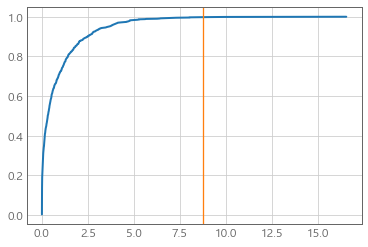

In [262]:
htchicont2.PlotCdf()

In [263]:
# Compare with my resampling function
def ResampleChiSquareContingency(observed, iters=1000):
    """Generates a chisquared statistic sampling distribution 
    from a contingency table. 
    Can then make an rv of this distribution to plot cdf and  
    compute a p-value for the actual chi-squared statistic (eg. rv.cdf at actual statistic (test_chi)). 
    Can also use the 'min' and 'max' built-ins to find what the most extreme values are from the simluations.

    Args:
        observed (array-like): observed contingency table
        iters (int, optional): Number of iterations to run when building distribution. Defaults to 1000.

    Returns:
        test_chi: Original actual chi squared value
        chis (array): Sampling distribution for the null hypothesis obtained from resampling
    """
    # Put the data into array form
    observed = np.asarray(observed, dtype=np.float64)
    
    # Calculate the test chi square statistic and the expected array
    test_chi,_,_,expected = stats.chi2_contingency(observed)
    
    # Calculate variables to be used in resampling
    expected = np.asarray(expected, dtype=np.float64)
    expected_shape = expected.shape
    expected_ps = expected / np.sum(expected)
    values = np.array(list(range(len(expected.ravel())))) # Flatten the array and then reshape it later
    n= int(np.sum(expected))
      
    # Compute resampled expected values and compute chi square 
    # to build a sampling distribution that represents the null hypothesis
    chis=[]
    for _ in range(iters):
        hist = Counter({x:0 for x in values}) # Initiate an empty histogram to hold resampled values
        hist.update(np.random.choice(values, size=n, replace=True, p=expected_ps.ravel()))
        sorted_hist = sorted(hist.items())
        resampled_expected = np.array([x[1] for x in sorted_hist])
        resampled_expected_reshaped = resampled_expected.reshape(expected_shape) # Put back into original shape

        chi = stats.chi2_contingency(resampled_expected_reshaped)[0]
        chis.append(chi)

    return test_chi, np.array(chis)

In [264]:
chicont2results = ResampleChiSquareContingency(observed)

In [265]:
# Results are 0.001~0.005
dsa.PValueFromEstimates(chicont2results[1], chicont2results[0])

0.0019999999999992246

In [266]:
# Need to also consider whether or not my original resampling functions should really return a test_stat.
# It doesn't seem like it really is a test_stat in the alternative hypothesis case
# It is actually just the original data statistic
# Is this really needed?